In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.5
  [a93c6f00] DataFrames v1.8.0
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [2]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [3]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:init_type, :T, :Lx, :Ly, :Mag, :Energy, :ηz, :ηxy]
)

cleandata (generic function with 1 method)

In [4]:
function generatePlot(data::AbstractDataFrame, x, y;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return ax
end

function generatePlot(data::AbstractDataFrame, x, ys::Vector;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for (label, y) in zip(ys, eachcol(data[:, ys]))
        vals = getfield.(y, :val)
        errs = getfield.(y, :err)
        scatter!(data[:, x], vals; label="$label")
        if line
            lines!(data[:, x], vals)
        end
        errorbars!(data[:, x], vals, errs)
    end
    axislegend()

    return ax
end

function generatePlot(data::GroupedDataFrame, x, y;
                      title, xlabel, ylabel, line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return ax
end

generatePlot (generic function with 3 methods)

In [19]:
jobname = "afm-fe"
data = cleandata("../jobs/" * jobname * ".results.json")

Row,init_type,T,Lx,Ly,Mag,Energy,ηz,ηxy
,String,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…
1,afm_fe,0.05,20,20,0.026±0.00012,-19.438±0.034,0.00051±0.00047,0.0599±0.00083
2,afm_fe,0.1,20,20,0.02606±0.00011,-19.408±0.038,0.00034±0.0005,0.0587±0.001
3,afm_fe,0.15,20,20,0.02614±0.00012,-19.342±0.027,-3.7e-5±0.00043,0.05981±0.00073
4,afm_fe,0.2,20,20,0.02596±0.00012,-19.315±0.016,0.00032±0.00045,0.0592±0.0011
5,afm_fe,0.25,20,20,0.02606±0.00015,-19.297±0.033,-0.00015±0.00042,0.05907±0.00071
6,afm_fe,0.3,20,20,0.02605±0.00013,-19.237±0.031,0.00063±0.00031,0.05911±0.00057
7,afm_fe,0.35,20,20,0.02603±0.00015,-19.24±0.031,-0.00061±0.00033,0.06002±0.00098
8,afm_fe,0.4,20,20,0.02634±0.00012,-19.221±0.037,0.00076±0.00054,0.05964±0.00078
9,afm_fe,0.45,20,20,0.02601±0.00014,-19.137±0.02,-0.00069±0.0005,0.05871±0.00068


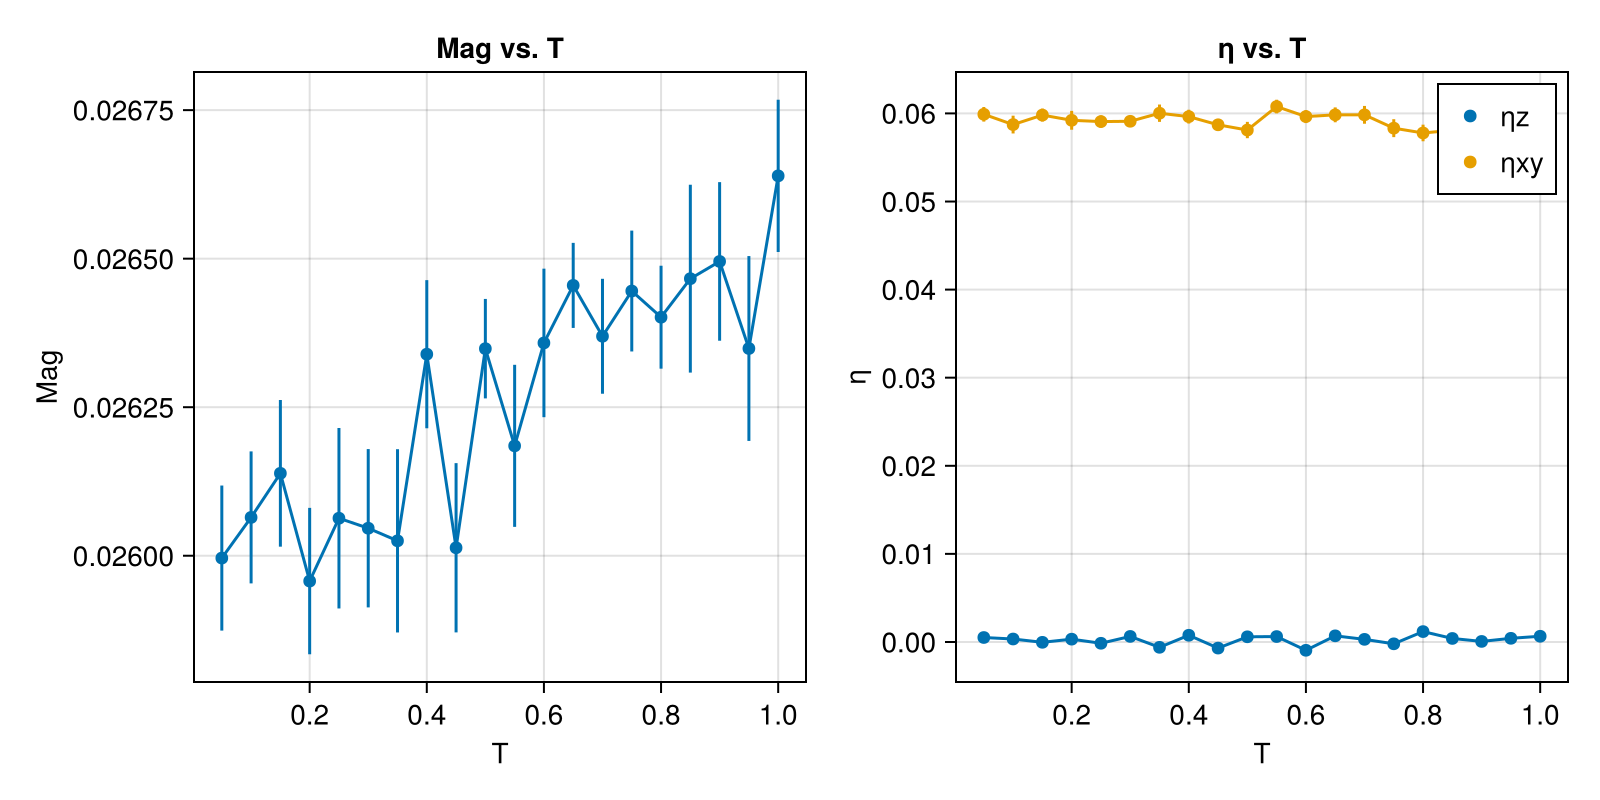

In [20]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

In [21]:
function generate_mctime_plot(task_no::Int, observable::Symbol, fig=Figure(size=(800, 400)),
                              fig_pos=(1, 1))
    ax = fig[fig_pos...] = Axis(
        fig,
        title="$observable vs. Bin #",
        xlabel="Bin #",
        ylabel="$observable",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]

        samples = read(observables, "$observable/samples")
        n = length(samples)
        init = 1
        lines!(ax, collect(1:n), samples[1:n])
    end

    return fig
end

generate_mctime_plot (generic function with 6 methods)

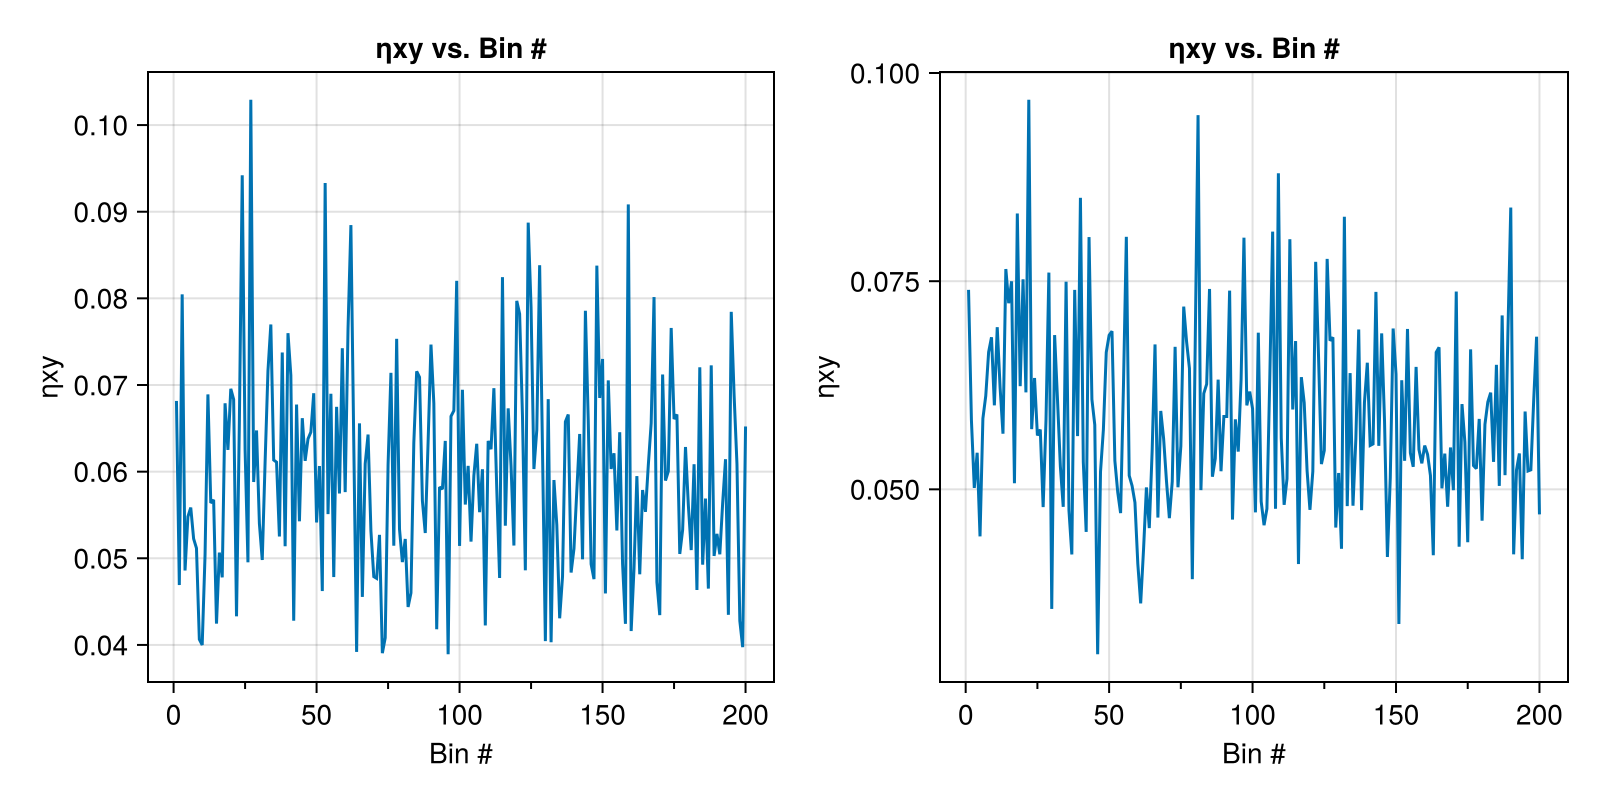

In [22]:
fig = Figure(size=(400, 800))
i = 1
fig = generate_mctime_plot(i, :ηxy)
generate_mctime_plot(i+1, :ηxy, fig, (1, 2))

In [23]:
function generate_spins(task_no::Int)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

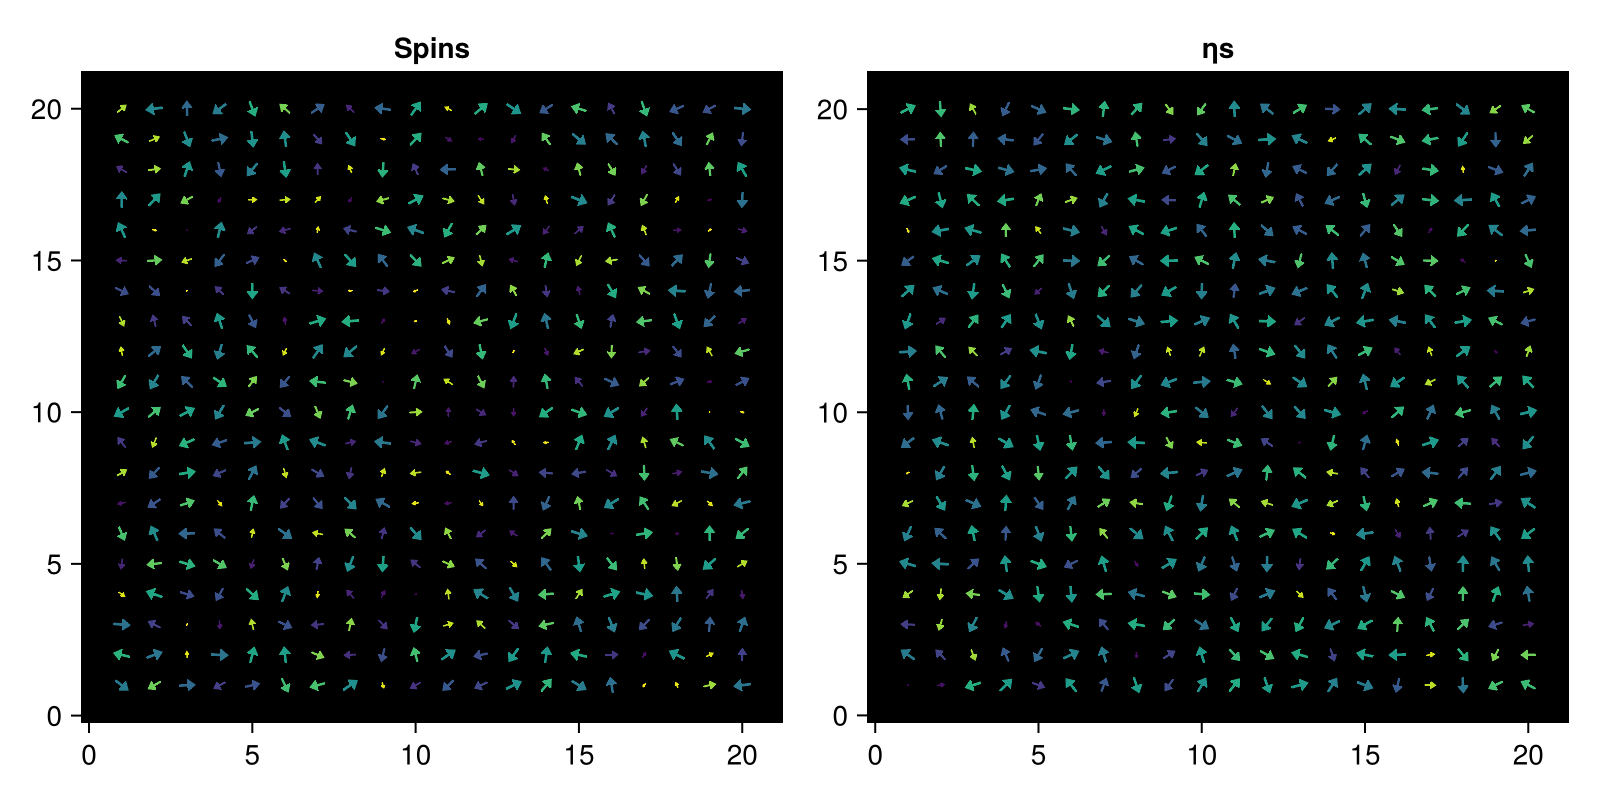

In [24]:
generate_spins(1)